In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [86]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [89]:
df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', index_col='Date', parse_dates=True)

In [90]:
df['LogClosing Price (USD)'] = np.log(df['Closing Price (USD)'])

In [91]:
df['DiffLogClosing Price (USD)'] = df['LogClosing Price (USD)'].diff()

In [92]:
Ntest = 100
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [93]:
# Make supervised dataset
# let's see if we can use T past values to predict the next value

series = df['DiffLogClosing Price (USD)'].to_numpy()[1:]

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2776, 10) Y.shape (2776,)


In [94]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [95]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.016223073748136585

In [96]:
lr.score(Xtest, Ytest)

0.002200301220753542

In [97]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T+1] = False # first T+1 values are not predictable

In [98]:
# Needed to compute un-differenced predictions
df['ShiftLogClosing Price (USD)'] = df['LogClosing Price (USD)'].shift(1)
prev = df['ShiftLogClosing Price (USD)']

In [99]:
# Last-known train value
last_train = train.iloc[-1]['LogClosing Price (USD)']

In [100]:
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(Xtest)

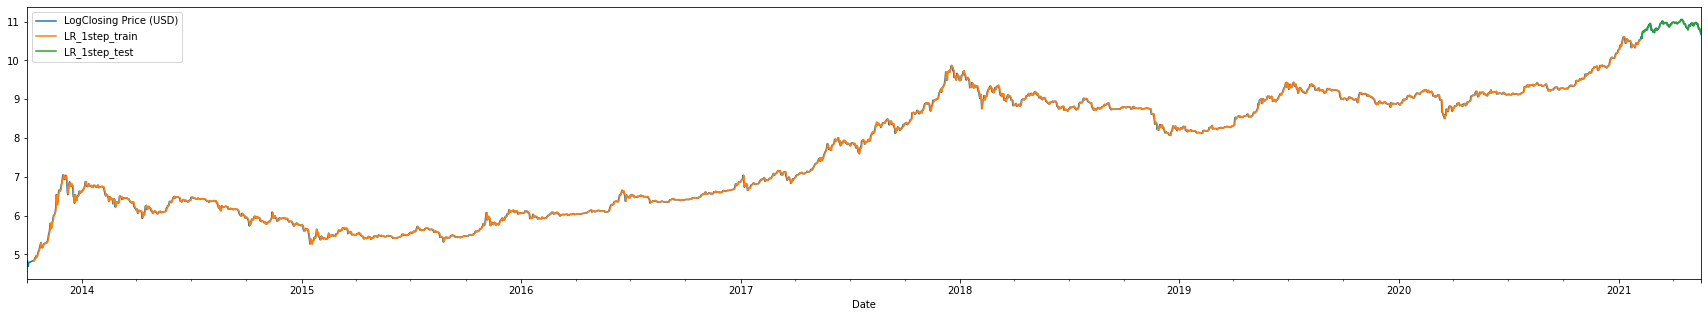

In [101]:
# plot 1-step forecast
df[['LogClosing Price (USD)', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(30, 5));

In [102]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = lr.predict(last_x.reshape(1, -1))[0]
  
  # update the predictions list
  multistep_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [103]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_predictions)

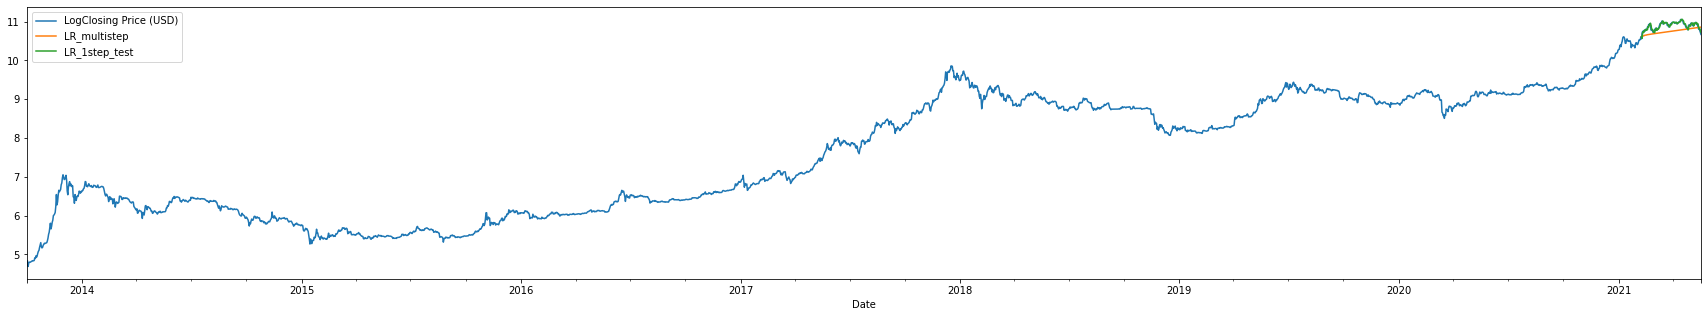

In [104]:
# plot 1-step and multi-step forecast
df[['LogClosing Price (USD)', 'LR_multistep', 'LR_1step_test']].plot(figsize=(30, 5));

In [105]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2677, 10) Y.shape (2677, 100)


In [106]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [107]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.006408472975976778

In [108]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

-116.68019642546557

In [109]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'LR_multioutput'] = last_train + \
  np.cumsum(lr.predict(Xtest_m).flatten())

Text(0.5, 1.0, 'FORECAST FOR NEXT 100 DAYS linear regression (with differencing) multi-step MAPE: 0.01396014489472451 multi-output MAPE: 0.01142426534415127')

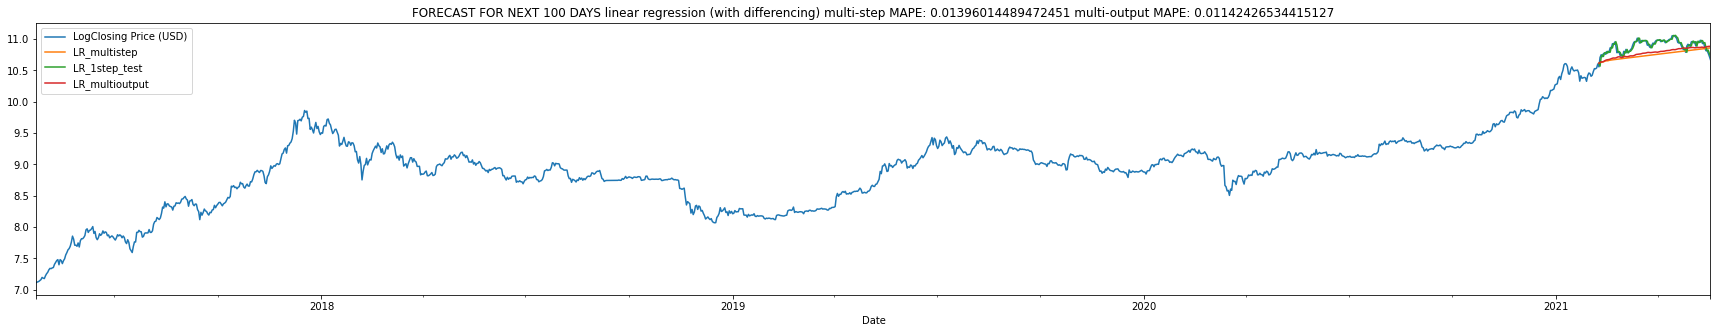

In [110]:
# plot all forecasts
cols = ['LogClosing Price (USD)', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols][1300:].plot(figsize=(30, 5));
plt.title('FORECAST FOR NEXT 100 DAYS linear regression (with differencing) multi-step MAPE: 0.01396014489472451 multi-output MAPE: 0.01142426534415127')

In [111]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogClosing Price (USD)']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'LR_multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.01396014489472451
multi-output MAPE: 0.01142426534415127


## Test Other Models

In [112]:
def one_step_and_multistep_forecast(model, name):
  model.fit(Xtrain, Ytrain)
  print("One-step forecast:", name)
  # print("Train R^2:", model.score(Xtrain, Ytrain))
  # print("Test R^2 (1-step):", model.score(Xtest, Ytest))

  # store 1-step forecast
  df.loc[train_idx, f'{name}_1step_train'] = \
    prev[train_idx] + model.predict(Xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = \
    prev[test_idx] + model.predict(Xtest)

  # generate multi-step forecast
  multistep_predictions = []

  # first test input
  last_x = Xtest[0]

  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]
    
    # update the predictions list
    multistep_predictions.append(p)
    
    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p
  
  # store multi-step forecast
  df.loc[test_idx, f'{name}_multistep_test'] = \
    last_train + np.cumsum(multistep_predictions)

  # MAPE of multi-step forecast
  mape = mean_absolute_percentage_error(
      test_log_pass, df.loc[test_idx, f'{name}_multistep_test'])
  print("Test MAPE (multi-step):", mape)

  # plot 1-step and multi-step forecast
  cols = [
    'LogClosing Price (USD)',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test'
  ]
  df[cols].plot(figsize=(30, 5));

One-step forecast: SVR
Test MAPE (multi-step): 0.026059405805892305


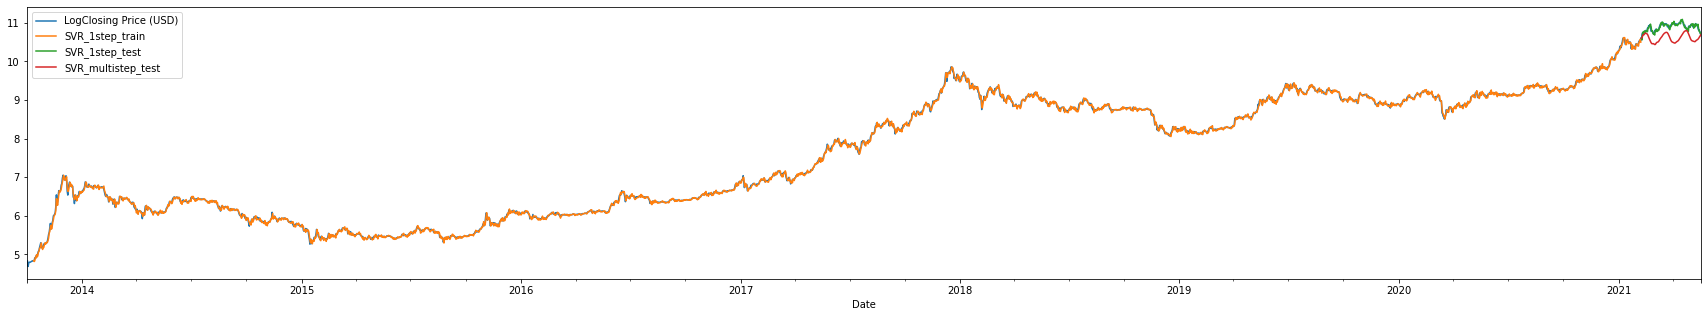

In [113]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Test MAPE (multi-step): 0.012234685642905146


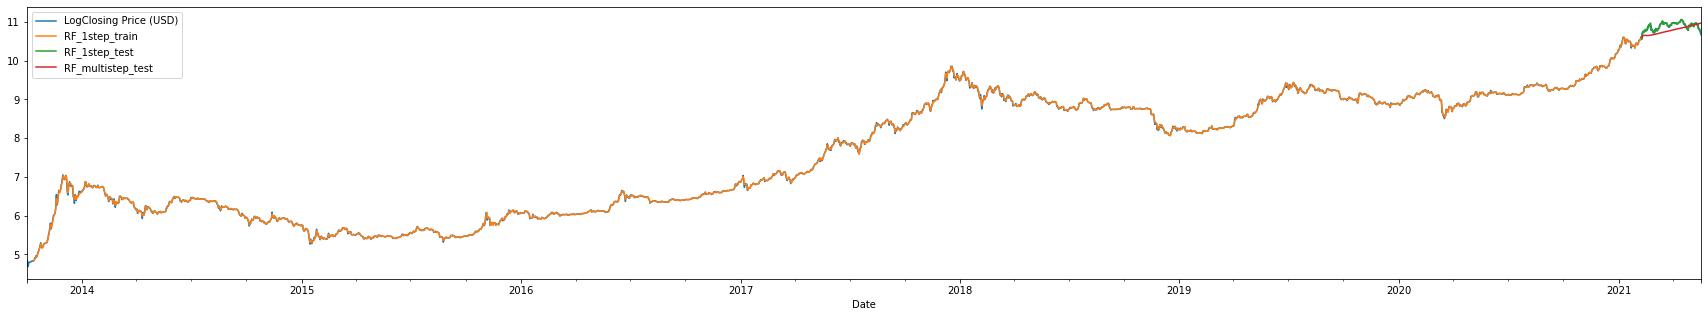

In [114]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [115]:
def multi_output_forecast(model, name):
  model.fit(Xtrain_m, Ytrain_m)
  
  # save multi-output forecast to dataframe
  df.loc[test_idx, f'{name}_multioutput'] = \
    last_train + np.cumsum(model.predict(Xtest_m).flatten())
  
  mape = mean_absolute_percentage_error(
      test_log_pass, df.loc[test_idx, f'{name}_multioutput'])
  print("Test MAPE (multi-output):", mape)

  # plot all forecasts
  # assume that previous functions have been run
  cols = [
    'LogClosing Price (USD)',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test',
    f'{name}_multioutput',
  ]
  df[cols][1300:].plot(figsize=(30, 5));

In [116]:
# multi_output_forecast(SVR(), "SVR") # cannot handle multi-output!

In [117]:
class SVRWrapper:
  def __init__(self, h, **args):
    self.h = h
    self.models = [SVR(**args) for _ in range(h)]
  
  def fit(self, X, Y):
    for k in range(self.h):
      self.models[k].fit(X, Y[:, k])
  
  def predict(self, X):
    P = [m.predict(X) for m in self.models]
    return np.hstack(P)


Test MAPE (multi-output): 0.01846672434223664


Text(0.5, 1.0, 'FORECAST FOR NEXT 100 DAYS support vector regression multi-step MAPE: 0.0260 multi-output MAPE: 0.0184')

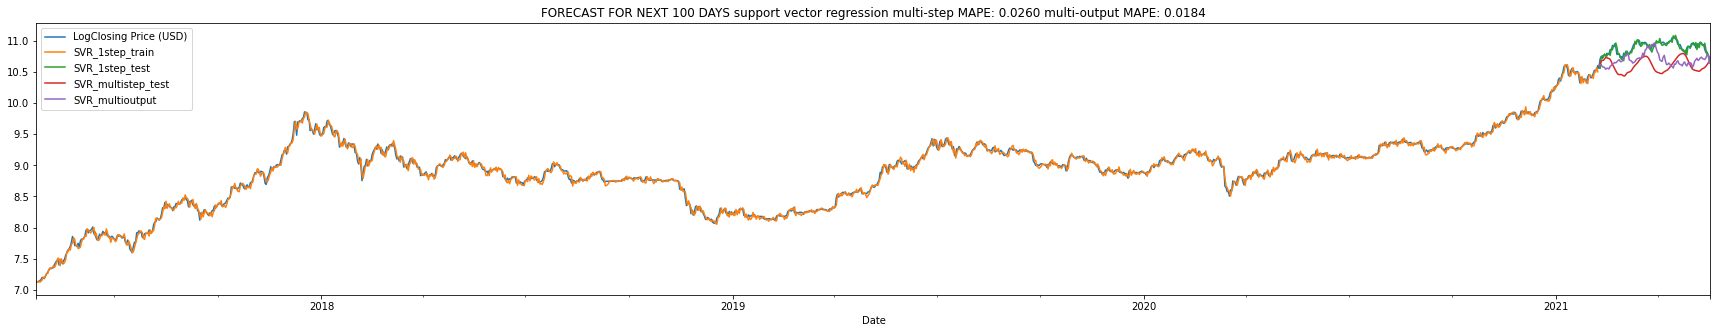

In [118]:
multi_output_forecast(SVRWrapper(Ntest), "SVR")
plt.title('FORECAST FOR NEXT 100 DAYS support vector regression multi-step MAPE: 0.0260 multi-output MAPE: 0.0184')

Test MAPE (multi-output): 0.0064993085524326765


Text(0.5, 1.0, 'FORECAST FOR NEXT 100 DAYS Randomforest(with differncing) multi-step MAPE: 0.0105 multi-output MAPE: 0.007')

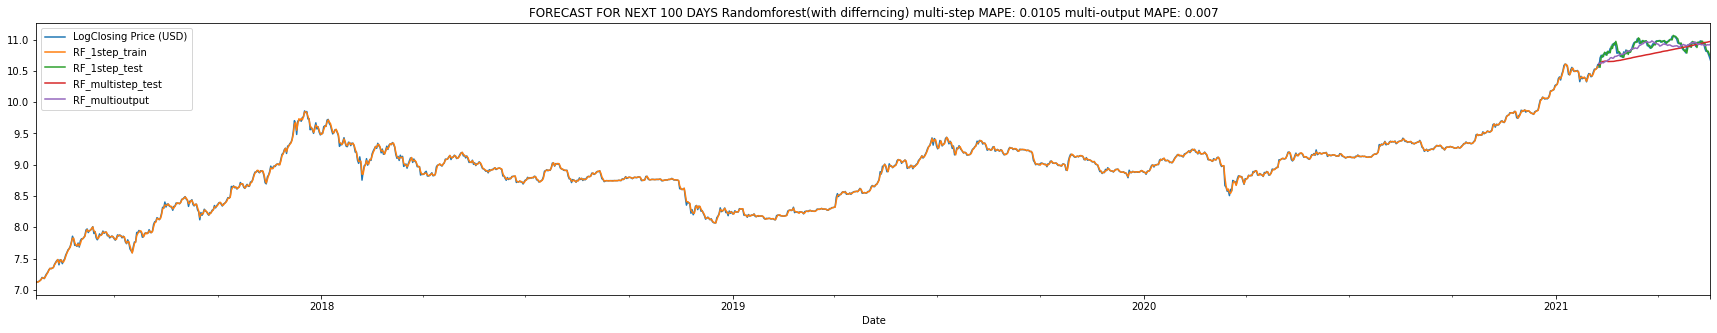

In [120]:
multi_output_forecast(RandomForestRegressor(), "RF")
plt.title('FORECAST FOR NEXT 100 DAYS Randomforest(with differncing) multi-step MAPE: 0.0105 multi-output MAPE: 0.007')